In [41]:
import torch
import triton
import triton.language as tl

DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}')

In [42]:
@triton.jit
def _layernorm_forward(
    x_ptr, y_ptr,
    w_ptr, b_ptr,
    mean_ptr, rstd_ptr,
    stride_M,
    N,
    eps,
    BLOCK_SIZE: tl.constexpr,  
    num_warps: tl.constexpr,
):
    row = tl.program_id(0)
    x_ptr += row * stride_M
    y_ptr += row * stride_M

    # mean 
    sum_accumulator = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
    for offset in range(0, N, BLOCK_SIZE):
        cols = offset + tl.arange(0, BLOCK_SIZE)
        x_ptrs = tl.load(x_ptr + cols, mask=cols < N, other=0.).to(tl.float32)
        sum_accumulator += x_ptrs
    mean = tl.sum(sum_accumulator, axis=0) / N

    acc = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
    for offset in range(0, N, BLOCK_SIZE):
        cols = offset + tl.arange(0, BLOCK_SIZE)
        x_ptrs = tl.load(x_ptr + cols, mask=cols < N, other=0.).to(tl.float32)
        diff = tl.where(cols < N, x_ptrs - mean, 0.)
        acc += diff * diff
    var = tl.sum(acc, axis=0) / N
    rstd = 1/tl.sqrt(var + eps)

    tl.store(mean_ptr + row, mean)
    tl.store(rstd_ptr + row, rstd)

    for offset in range(0, N, BLOCK_SIZE):
        cols = offset + tl.arange(0, BLOCK_SIZE)
        mask = cols < N
        w_ptrs = tl.load(w_ptr + cols, mask=mask)
        b_ptrs = tl.load(b_ptr + cols, mask=mask)
        x_ptrs = tl.load(x_ptr + cols, mask=mask)

        x_hat = (x_ptrs - mean) * rstd
        y = x_hat * w_ptrs + b_ptrs

        tl.store(y_ptr + cols, y, mask=mask)
    


In [43]:
@triton.jit
def _layernorm_backward_dLdx(
  x_ptr, 
  dLdx_ptr,
  dLdy_ptr,
  w_ptr,
  dLdw_inter_ptr,
  dLdb_inter_ptr,
  mean_ptr,
  rstd_ptr,
  locks_ptr,
  stride, 
  N,
  GROUP_SIZE: tl.constexpr,
  BLOCK_SIZE_N: tl.constexpr  
):
    PID = tl.program_id(0)
    cols = tl.arange(0, BLOCK_SIZE_N)
    mask = cols < N
    x_ptr += PID * stride
    dLdx_ptr += PID * stride
    dLdy_ptr += PID * stride

    x = tl.load(x_ptr + cols, mask=mask, other=0).to(tl.float32)
    dLdy = tl.load(dLdy_ptr + cols, mask=mask, other=0).to(tl.float32)
    w = tl.load(w_ptr + cols, mask=mask).to(tl.float32)
    mean = tl.load(mean_ptr + PID)
    rstd = tl.load(rstd_ptr + PID)

    x_norm = tl.where(mask, (x-mean)*rstd, 0.)
    dydx_norm = tl.where(mask, w * dLdy, 0.)
    c1 = tl.sum(x_norm * dydx_norm, axis=0) / N
    c2 = tl.sum(dydx_norm, axis=0) / N
    dLdx = (dydx_norm - (x_norm * c1 + c2)) * rstd

    tl.store(dLdx_ptr + cols, dLdx, mask=mask)

    dLdw_contri = (dLdy * x_norm).to(w.dtype)
    dldb_contri = (dLdy).to(w.dtype)

    lock_id = PID % GROUP_SIZE
    locks_ptr += lock_id
    count_ptr = locks_ptr + GROUP_SIZE
    
    dLdw_inter_ptrs = dLdw_inter_ptr + lock_id * N + cols
    dLdb_inter_ptrs = dLdb_inter_ptr + lock_id * N + cols

    while tl.atomic_cas(locks_ptr, 0, 1) == 1:
      pass
    # locked
    count = tl.load(count_ptr)
    if count == 0:
      tl.atomic_xchg(count_ptr, 1)
    else:
      dLdw_contri += tl.load(dLdw_inter_ptrs, mask=mask)
      dldb_contri += tl.load(dLdb_inter_ptrs, mask=mask)

    tl.store(dLdw_inter_ptrs, dLdw_contri, mask=mask)
    tl.store(dLdb_inter_ptrs, dldb_contri, mask=mask)

    # unlocked
    tl.atomic_xchg(locks_ptr, 0)


In [44]:
@triton.jit
def _layernorm_backward_dLdw_dLdb(
    dLdw_inter_ptr,
    dLdb_inter_ptr,
    dLdw_ptr,
    dLdb_ptr,
    GROUP_SIZE,
    N,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
):
    PID = tl.program_id(0)
    col_ptrs = PID * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)

    dLdw_acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    dLdb_acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)

    for i in range(0, GROUP_SIZE, BLOCK_SIZE_M):
        row_ptrs = i + tl.arange(0, BLOCK_SIZE_M)
        mask = (row_ptrs[:, None] < GROUP_SIZE) & (col_ptrs[None,:] < N)
        offsets = row_ptrs[:, None] * N + col_ptrs[None, :]
        dLdw_acc += tl.load(dLdw_inter_ptr + offsets, mask=mask, other=0.)
        dLdb_acc += tl.load(dLdb_inter_ptr + offsets, mask=mask, other=0.)
    
    sum_dLdw = tl.sum(dLdw_acc, axis=0)
    sum_dLdb = tl.sum(dLdb_acc, axis=0)

    tl.store(dLdw_ptr + col_ptrs, sum_dLdw, mask=col_ptrs < N)
    tl.store(dLdb_ptr + col_ptrs, sum_dLdb, mask=col_ptrs < N)


In [45]:
class LayerNorm(torch.autograd.Function):
    @staticmethod
    def forward(
        ctx, 
        x, 
        normalized_shape, 
        weight, 
        bias, 
        eps
    ):
        M, N = x.reshape(-1, x.shape[-1]).shape
        mean = torch.empty((M,), dtype=torch.float32, device=x.device)
        rstd = torch.empty((M,), dtype=torch.float32, device=x.device)
        y = torch.empty_like(x)

        # 64KB per SRAM
        MAX_FUSED_SIZE = 65536 // x.element_size()
        BLOCK_SIZE = min(MAX_FUSED_SIZE, triton.next_power_of_2(N))

        num_warps = min(max(BLOCK_SIZE//256, 1), 8)

        _layernorm_forward[(M,)](
            x, y, weight, bias,
            mean, rstd,
            x.stride(0),
            N, 
            eps,
            BLOCK_SIZE=BLOCK_SIZE, 
            num_warps=num_warps,
        )
        
        ctx.save_for_backward(x, weight, bias, mean, rstd)
        ctx.BLOCK_SIZE = BLOCK_SIZE
        ctx.num_warps = num_warps
        ctx.eps = eps

        return y

    @staticmethod
    def backward(
        ctx, 
        dLdy
    ):
        x, w, b, mean, rstd = ctx.saved_tensors
        M, N = x.reshape(-1, x.shape[-1]).shape

        dLdw = torch.empty((N,), dtype=w.dtype, device=w.device)
        dLdb = torch.empty((N,), dtype=b.dtype, device=w.device)
        dLdx = torch.empty_like(dLdy)

        GROUP_SIZE =64
        if N <= 8192: GROUP_SIZE = 96
        if N <= 4096: GROUP_SIZE = 128
        if N <= 1024: GROUP_SIZE = 256

        dLdw_inter = torch.zeros((GROUP_SIZE, N), dtype=x.dtype, device=w.device)
        dLdb_inter = torch.zeros((GROUP_SIZE, N), dtype=x.dtype, device=w.device)

        locks = torch.zeros(2 * GROUP_SIZE, dtype=torch.int32, device=w.device)

        _layernorm_backward_dLdx[(M, )](
            x, dLdx, dLdy,
            w, dLdw_inter, dLdb_inter,
            mean, rstd,
            locks,
            x.stride(0), 
            N,
            GROUP_SIZE=GROUP_SIZE,
            BLOCK_SIZE_N = ctx.BLOCK_SIZE,
            num_warps = ctx.num_warps
        )
        grid = lambda meta: [triton.cdiv(N, meta['BLOCK_SIZE_N'])]
        _layernorm_backward_dLdw_dLdb[grid](
            dLdw_inter,
            dLdb_inter,
            dLdw,
            dLdb,
            min(GROUP_SIZE, M),
            N,
            BLOCK_SIZE_M=32,
            BLOCK_SIZE_N=128,
        )
        
        return dLdx, None, dLdw, dLdb, None


layernorm = LayerNorm.apply 

In [46]:
# step 1 unit test
def test_layernorm_kernel(M, N, dtype, eps=1e-5, device=DEVICE):
    # create data
    x = -2.3 + 0.5 * torch.randn((M, N), dtype=dtype, device=device)
    weight = torch.randn((N,), dtype=dtype, device=device, requires_grad=True)
    bias = torch.randn((N,), dtype=dtype, device=device, requires_grad=True)
    dLdy = .1 * torch.randn_like(x)
    x.requires_grad_(True)

    # forward pass
    y_tri = layernorm(x, (N,), weight, bias, eps)
    y_ref = torch.nn.functional.layer_norm(x, (N,), weight, bias, eps).to(dtype)

    torch.testing.assert_close(y_tri, y_ref, atol=1e-2, rtol=0)
    print('forward test passed')

    y_tri.backward(dLdy, retain_graph=True)
    dLdx_tri, dLdw_tri, dLdb_tri = [_.grad.clone() for _ in [x, weight, bias]]
    x.grad, weight.grad, bias.grad = None, None, None

    y_ref.backward(dLdy, retain_graph=True)
    dLdx_ref, dLdw_ref, dLdb_ref = [_.grad.clone() for _ in [x, weight, bias]]

    torch.testing.assert_close(dLdx_tri, dLdx_ref, atol=1e-2, rtol=0)
    torch.testing.assert_close(dLdw_tri, dLdw_ref, atol=1e-2, rtol=0)
    torch.testing.assert_close(dLdb_tri, dLdb_ref, atol=1e-2, rtol=0)
    
    print('backward test passed')


In [48]:
test_layernorm_kernel(1151, 8192, torch.float16)

forward test passed
backward test passed


In [54]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[512 * i for i in range(2, 32)], 
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='GB/s',
        plot_name='layer-norm-backward',
        args={'M': 4096, 'dtype': torch.float16, 'mode': 'backward'}, 
    )
)
def benchmark(
    M, N,
    dtype,
    provider,
    mode='backward',
    eps=1e-5,
    device=DEVICE,
):
    x_shape = (M, N)
    w_shape = (N, )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)#, requires_grad=True)
    dLdy = .1 * torch.randn_like(x)
    x.requires_grad_(True) 

    quantiles = [0.5, 0.05, 0.95]

    def y_fwd():
        if provider == "triton":
            return layernorm(x, w_shape, weight, bias, eps) 
        if provider == "torch":
            return torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps) 

    if mode == 'forward':
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, quantiles=quantiles, rep=500)
    if mode == 'backward':
        y = y_fwd()
        gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: y.backward(dLdy, retain_graph=True),
            quantiles=quantiles,
            grad_to_none=[x],
            rep=500)

    return gbps(ms), gbps(max_ms), gbps(min_ms)

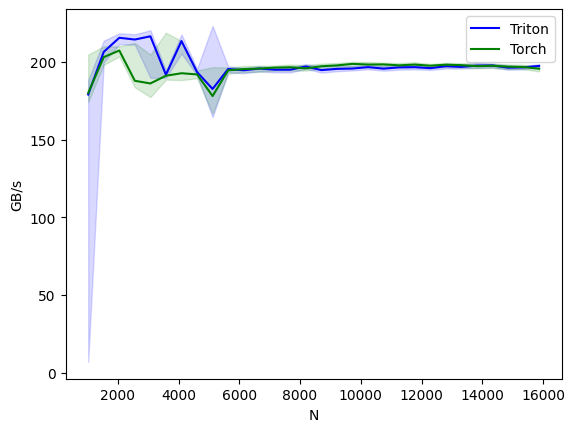

In [ ]:
benchmark.run(print_data=False,mode='forward')

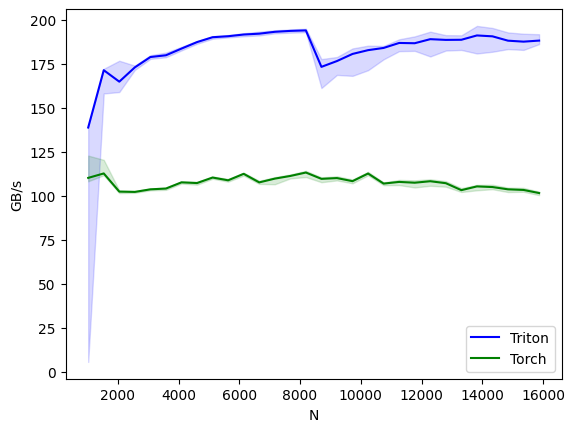

In [ ]:
benchmark.run(print_data=False,mode='backward')